# Local set up

In [1]:
# Step 1 
import pandas as pd

In [2]:
# Step 2
from sqlalchemy import create_engine 

In [3]:
# Step 3
import sqlalchemy
print(sqlalchemy.__version__) # check version is 1.4.49

1.4.49


In [4]:
# Step 4
engine = create_engine("postgresql://nicolieng@localhost:5432/nicolieng")

In [5]:
# Step 5
engine.connect()

In [6]:
# Step 6 - checking connection
query= """
SELECT 1 as number;
"""

pd.read_sql(query, con=engine)

,number
0,1


In [34]:
# Step 7 - import new csv here 
drg = pd.read_csv('Case_Study.csv') #substitute any new csv here

In [ ]:
# Step 8 - preview your data, make sure it's correctly imported with the right data types
drg.head()


,USER_ID,TIMESTAMP,STEP_COMPLETED,CHANNEL
0,0039d600-ae04-42a7-a9ca-b0150e488cfa,2025-03-04 15:33:28,email_submit,Organic
1,0039d600-ae04-42a7-a9ca-b0150e488cfa,2025-03-04 15:33:34,contact_info,Organic
2,0039d600-ae04-42a7-a9ca-b0150e488cfa,2025-03-04 15:33:37,company_size,Organic
3,0039d600-ae04-42a7-a9ca-b0150e488cfa,2025-03-04 15:33:40,industry,Organic
4,0039d600-ae04-42a7-a9ca-b0150e488cfa,2025-03-04 15:33:47,company_info,Organic


In [ ]:
drg.columns = drg.columns.str.lower()
drg['timestamp'] = pd.to_datetime(drg['timestamp'])



In [19]:
# Step 9 - IMPORTANT STEP, this programs picks up schema automatically 
print(pd.io.sql.get_schema(drg, name = 'hcp_case_study'))

CREATE TABLE "hcp_case_study" (
"user_id" TEXT,
  "timestamp" TIMESTAMP,
  "step_completed" TEXT,
  "channel" TEXT
)


# Loading the csv as a sql table

In [ ]:

drg.to_sql(name='funnelhcp',con=engine,index=False) 

819

In [ ]:
# preview data table
query="""
SELECT *
FROM funnelhcp limit 10;
"""

pd.read_sql(query,con=engine)

,user_id,timestamp,step_completed,channel
0,0039d600-ae04-42a7-a9ca-b0150e488cfa,2025-03-04 15:33:28,email_submit,Organic
1,0039d600-ae04-42a7-a9ca-b0150e488cfa,2025-03-04 15:33:34,contact_info,Organic
2,0039d600-ae04-42a7-a9ca-b0150e488cfa,2025-03-04 15:33:37,company_size,Organic
3,0039d600-ae04-42a7-a9ca-b0150e488cfa,2025-03-04 15:33:40,industry,Organic
4,0039d600-ae04-42a7-a9ca-b0150e488cfa,2025-03-04 15:33:47,company_info,Organic
5,0039d600-ae04-42a7-a9ca-b0150e488cfa,2025-03-04 15:33:56,set_password,Organic
6,0039d600-ae04-42a7-a9ca-b0150e488cfa,2025-03-04 15:35:51,trial_started,Organic
7,003f980c-fac3-4c67-9479-3b7ab884d868,2025-03-10 22:01:17,email_submit,Paid
8,003f980c-fac3-4c67-9479-3b7ab884d868,2025-03-10 22:01:38,contact_info,Paid
9,003f980c-fac3-4c67-9479-3b7ab884d868,2025-03-10 22:01:50,company_size,Paid


In [ ]:
#Find users who started trial and completed previous steps outside of March. I'm excluding them in this analysis because we dont have the full picture of their timeline moving through the funnel
    
query="""
SELECT * from funnelhcp where user_id IN (
select user_id
FROM funnelhcp group by 1 having count(*)= 1 ) and step_completed = 'trial_started';
"""

pd.read_sql(query,con=engine)

,user_id,timestamp,step_completed,channel
0,0102e4df-178f-4771-9fd0-b821893a6c6e,2025-03-03 12:06:02,trial_started,Paid
1,014dc5ff-7c34-4765-8187-d70e8b3afc27,2025-03-06 18:17:29,trial_started,Paid
2,018d77c2-2dbe-4e01-9b51-cc1c5cc688d2,2025-03-10 13:17:30,trial_started,Organic
3,025c5b8c-34a6-4e12-8fbf-bce1c572eac0,2025-03-03 17:11:38,trial_started,Organic
4,04bfbea6-2396-4c18-bb72-ea338b691f59,2025-03-10 09:18:36,trial_started,Organic
...,...,...,...,...
193,f875b3aa-1122-47f9-b300-9e431d31e010,2025-03-01 17:48:13,trial_started,Organic
194,fa4f2403-bb21-40e3-a2fb-5efa6343abdb,2025-03-02 15:28:23,trial_started,Organic
195,fc79133a-58db-4531-9bad-8bba0eab703c,2025-03-04 11:36:57,trial_started,Organic
196,fd4adef1-14b4-4fb3-84c1-3cbff3b0531b,2025-03-01 08:54:01,trial_started,Paid


In [ ]:
#Find out distribution of excluded users. 
query="""
with cte as (SELECT * from funnelhcp where user_id IN (
select user_id
FROM funnelhcp group by 1 having count(*)= 1 ) and step_completed = 'trial_started') 

SELECT channel, count(distinct user_id) from cte
group by 1;
"""

pd.read_sql(query,con=engine)

,channel,count
0,Organic,76
1,Paid,118
2,Product,4


In [51]:
query="""
CREATE TABLE step AS 
SELECT *,
    CASE 
        WHEN step_completed = 'email_submit' THEN 1
        WHEN step_completed = 'contact_info' THEN 2
        WHEN step_completed = 'company_size' THEN 3
        WHEN step_completed = 'industry' THEN 4
        WHEN step_completed = 'company_info' THEN 5
        WHEN step_completed = 'set_password' THEN 6
        WHEN step_completed = 'trial_started' THEN 7
        ELSE 0
    END AS step_no
FROM funnelhcp
WHERE user_id NOT IN (
    SELECT user_id 
    FROM funnelhcp 
    WHERE user_id IN (
        SELECT user_id
        FROM funnelhcp 
        GROUP BY user_id 
        HAVING COUNT(*) = 1
    ) 
    AND step_completed = 'trial_started'
);
"""

pd.read_sql(query,con=engine)

ResourceClosedError: This result object does not return rows. It has been closed automatically.

In [62]:
query="""
SELECT * 
FROM step limit 5 ;
"""
pd.read_sql(query,con=engine)

,user_id,timestamp,step_completed,channel,step_no
0,0039d600-ae04-42a7-a9ca-b0150e488cfa,2025-03-04 15:33:28,email_submit,Organic,1
1,0039d600-ae04-42a7-a9ca-b0150e488cfa,2025-03-04 15:33:34,contact_info,Organic,2
2,0039d600-ae04-42a7-a9ca-b0150e488cfa,2025-03-04 15:33:37,company_size,Organic,3
3,0039d600-ae04-42a7-a9ca-b0150e488cfa,2025-03-04 15:33:40,industry,Organic,4
4,0039d600-ae04-42a7-a9ca-b0150e488cfa,2025-03-04 15:33:47,company_info,Organic,5


In [ ]:
#Calculate conversion rates and drop-off rates for all stages. 
query="""
WITH users_per_step as (
SELECT step_no, step_completed, count(distinct user_id) as users
FROM step group by 1,2 order by 1  
), 
funnel AS (
    SELECT 
        step_no,
        step_completed,
        users,
        LAG(users) OVER (ORDER BY step_no) AS previous_users
    FROM users_per_step
)
SELECT 
    step_no,
    step_completed,
    users,
    ROUND(
        CASE 
            WHEN previous_users IS NULL THEN NULL  
            ELSE (1.0*users/ previous_users) * 100
        END, 
        1
    ) AS conversion_rate,
    ROUND(
        CASE 
            WHEN previous_users IS NULL THEN NULL
            ELSE 100 - ((1.0 * users/ previous_users) * 100)
        END, 
        1
    ) AS drop_off_rate
FROM funnel
ORDER BY step_no;

"""

pd.read_sql(query,con=engine)


,step_no,step_completed,users,conversion_rate,drop_off_rate
0,1,email_submit,3341,NaN,NaN
1,2,contact_info,2634,78.8,21.2
2,3,company_size,2457,93.3,6.7
3,4,industry,2371,96.5,3.5
4,5,company_info,2145,90.5,9.5
5,6,set_password,1513,70.5,29.5
6,7,trial_started,1109,73.3,26.7


posx and posy should be finite values
posx and posy should be finite values


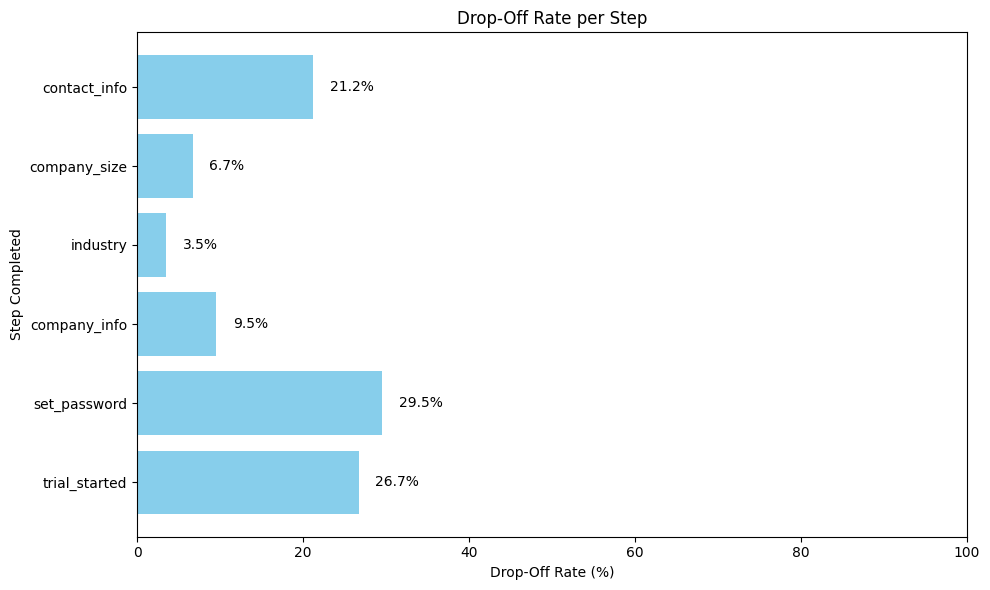

In [97]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the DataFrame
data = {
    'step_no': [1, 2, 3, 4, 5, 6, 7],
    'step_completed': ['email_submit', 'contact_info', 'company_size', 'industry', 'company_info', 'set_password', 'trial_started'],
    'drop_off_rate': [None, 21.2, 6.7, 3.5, 9.5, 29.5, 26.7]
}

df = pd.DataFrame(data)

# Sort by step_no to make sure order is correct and reverse it for top-down order
df = df.sort_values('step_no', ascending=True)

# Plot
plt.figure(figsize=(10,6))
bars = plt.barh(df['step_completed'], df['drop_off_rate'], color='skyblue')
plt.xlabel('Drop-Off Rate (%)')
plt.ylabel('Step Completed')
plt.title('Drop-Off Rate per Step')
plt.xlim(0, 100)
plt.gca().invert_yaxis()  # Invert y-axis so it starts with email_submit on top
plt.grid(axis='x', linestyle='--', alpha=0)

for bar in bars:
    width = bar.get_width()
    if width:  # Only add label if width is not None
        plt.text(width + 2,               # a little to the right of the bar
                 bar.get_y() + bar.get_height()/2,  # vertically centered
                 f'{width:.1f}%',          # formatted as percentage
                 va='center')

plt.tight_layout()
plt.show()



In [ ]:
# Let's analyze the funnel and compute conversion, and drop-off rates, for users coming from Organic acquisition channel
query="""
WITH users_per_step as (
SELECT step_no, step_completed, count(distinct user_id) as users
FROM step where channel = 'Organic' group by 1,2 order by 1  
), 
funnel AS (
    SELECT 
        step_no,
        step_completed,
        users,
        LAG(users) OVER (ORDER BY step_no) AS previous_users
    FROM users_per_step
)
SELECT 
    step_no,
    step_completed,
    users,
    ROUND(
        CASE 
            WHEN previous_users IS NULL THEN NULL  
            ELSE (1.0*users/ previous_users) * 100
        END, 
        1
    ) AS conversion_rate,
    ROUND(
        CASE 
            WHEN previous_users IS NULL THEN NULL
            ELSE 100 - ((1.0 * users/ previous_users) * 100)
        END, 
        1
    ) AS drop_off_rate
FROM funnel
ORDER BY step_no;

"""

pd.read_sql(query,con=engine)


,step_no,step_completed,users,conversion_rate,drop_off_rate
0,1,email_submit,637,NaN,NaN
1,2,contact_info,525,82.4,17.6
2,3,company_size,484,92.2,7.8
3,4,industry,472,97.5,2.5
4,5,company_info,439,93.0,7.0
5,6,set_password,336,76.5,23.5
6,7,trial_started,274,81.5,18.5


In [ ]:
# Let's see how the funnel and conversion rates look like from the Product acquisition channel

query="""
WITH users_per_step as (
SELECT step_no, step_completed, count(distinct user_id) as users
FROM step where channel = 'Product'  group by 1,2 order by 1  
), 
funnel AS (
    SELECT 
        step_no,
        step_completed,
        users,
        LAG(users) OVER (ORDER BY step_no) AS previous_users
    FROM users_per_step
)
SELECT 
    step_no,
    step_completed,
    users,
    ROUND(
        CASE 
            WHEN previous_users IS NULL THEN NULL  
            ELSE (1.0*users/ previous_users) * 100
        END, 
        1
    ) AS conversion_rate,
    ROUND(
        CASE 
            WHEN previous_users IS NULL THEN NULL
            ELSE 100 - ((1.0 * users/ previous_users) * 100)
        END, 
        1
    ) AS drop_off_rate
FROM funnel
ORDER BY step_no;

"""

pd.read_sql(query,con=engine)


,step_no,step_completed,users,conversion_rate,drop_off_rate
0,1,email_submit,781,NaN,NaN
1,2,contact_info,527,67.5,32.5
2,3,company_size,466,88.4,11.6
3,4,industry,444,95.3,4.7
4,5,company_info,408,91.9,8.1
5,6,set_password,275,67.4,32.6
6,7,trial_started,2,0.7,99.3


In [ ]:
# Let's see how the funnel and conversion rates look like for Paid Channel 
query="""
WITH users_per_step as (
SELECT step_no, step_completed, count(distinct user_id) as users
FROM step where channel = 'Paid' group by 1,2 order by 1  
), 
funnel AS (
    SELECT 
        step_no,
        step_completed,
        users,
        LAG(users) OVER (ORDER BY step_no) AS previous_users
    FROM users_per_step
)
SELECT 
    step_no,
    step_completed,
    users,
    ROUND(
        CASE 
            WHEN previous_users IS NULL THEN NULL  
            ELSE (1.0*users/ previous_users) * 100
        END, 
        1
    ) AS conversion_rate,
    ROUND(
        CASE 
            WHEN previous_users IS NULL THEN NULL
            ELSE 100 - ((1.0 * users/ previous_users) * 100)
        END, 
        1
    ) AS drop_off_rate
FROM funnel
ORDER BY step_no;

"""

pd.read_sql(query,con=engine)


,step_no,step_completed,users,conversion_rate,drop_off_rate
0,1,email_submit,1923,NaN,NaN
1,2,contact_info,1582,82.3,17.7
2,3,company_size,1507,95.3,4.7
3,4,industry,1455,96.5,3.5
4,5,company_info,1298,89.2,10.8
5,6,set_password,902,69.5,30.5
6,7,trial_started,833,92.4,7.6


In [ ]:
#Create new variable - time_of_day to start cohort analysis
query=""" 
ALTER TABLE step ADD COLUMN time_of_day TEXT;

UPDATE step
SET time_of_day = CASE 
    WHEN EXTRACT(HOUR FROM timestamp) >= 2 AND EXTRACT(HOUR FROM timestamp) < 10 THEN 'morning'
    WHEN EXTRACT(HOUR FROM timestamp) >= 10 AND EXTRACT(HOUR FROM timestamp) < 18 THEN 'afternoon'
    ELSE 'night'
END;
"""

pd.read_sql(query,con=engine)

ResourceClosedError: This result object does not return rows. It has been closed automatically.

In [100]:
query="""
WITH users_per_step as (
SELECT step_no, step_completed, count(distinct user_id) as users
FROM step where time_of_day = 'night' group by 1,2 order by 1  
), 
funnel AS (
    SELECT 
        step_no,
        step_completed,
        users,
        LAG(users) OVER (ORDER BY step_no) AS previous_users
    FROM users_per_step
)
SELECT 
    step_no,
    step_completed,
    users,
    ROUND(
        CASE 
            WHEN previous_users IS NULL THEN NULL  
            ELSE (1.0*users/ previous_users) * 100
        END, 
        1
    ) AS conversion_rate,
    ROUND(
        CASE 
            WHEN previous_users IS NULL THEN NULL
            ELSE 100 - ((1.0 * users/ previous_users) * 100)
        END, 
        1
    ) AS drop_off_rate
FROM funnel
ORDER BY step_no;

"""

pd.read_sql(query,con=engine)


,step_no,step_completed,users,conversion_rate,drop_off_rate
0,1,email_submit,736,NaN,NaN
1,2,contact_info,616,83.7,16.3
2,3,company_size,581,94.3,5.7
3,4,industry,559,96.2,3.8
4,5,company_info,515,92.1,7.9
5,6,set_password,341,66.2,33.8
6,7,trial_started,253,74.2,25.8


In [80]:
query="""
WITH users_per_step as (
SELECT step_no, step_completed, count(distinct user_id) as users
FROM step where time_of_day = 'morning' group by 1,2 order by 1  
), 
funnel AS (
    SELECT 
        step_no,
        step_completed,
        users,
        LAG(users) OVER (ORDER BY step_no) AS previous_users
    FROM users_per_step
)
SELECT 
    step_no,
    step_completed,
    users,
    ROUND(
        CASE 
            WHEN previous_users IS NULL THEN NULL  
            ELSE (1.0*users/ previous_users) * 100
        END, 
        1
    ) AS conversion_rate,
    ROUND(
        CASE 
            WHEN previous_users IS NULL THEN NULL
            ELSE 100 - ((1.0 * users/ previous_users) * 100)
        END, 
        1
    ) AS drop_off_rate
FROM funnel
ORDER BY step_no;

"""

pd.read_sql(query,con=engine)

,step_no,step_completed,users,conversion_rate,drop_off_rate
0,1,email_submit,1049,NaN,NaN
1,2,contact_info,809,77.1,22.9
2,3,company_size,736,91.0,9.0
3,4,industry,709,96.3,3.7
4,5,company_info,641,90.4,9.6
5,6,set_password,467,72.9,27.1
6,7,trial_started,338,72.4,27.6


In [99]:
query="""
WITH users_per_step as (
SELECT step_no, step_completed, count(distinct user_id) as users
FROM step where time_of_day = 'afternoon' group by 1,2 order by 1  
), 
funnel AS (
    SELECT 
        step_no,
        step_completed,
        users,
        LAG(users) OVER (ORDER BY step_no) AS previous_users
    FROM users_per_step
)
SELECT 
    step_no,
    step_completed,
    users,
    ROUND(
        CASE 
            WHEN previous_users IS NULL THEN NULL  
            ELSE (1.0*users/ previous_users) * 100
        END, 
        1
    ) AS conversion_rate,
    ROUND(
        CASE 
            WHEN previous_users IS NULL THEN NULL
            ELSE 100 - ((1.0 * users/ previous_users) * 100)
        END, 
        1
    ) AS drop_off_rate
FROM funnel
ORDER BY step_no;

"""

pd.read_sql(query,con=engine)

,step_no,step_completed,users,conversion_rate,drop_off_rate
0,1,email_submit,1575,NaN,NaN
1,2,contact_info,1219,77.4,22.6
2,3,company_size,1148,94.2,5.8
3,4,industry,1109,96.6,3.4
4,5,company_info,994,89.6,10.4
5,6,set_password,707,71.1,28.9
6,7,trial_started,518,73.3,26.7


In [ ]:
#Adding a second variable - weekday_or_weekend

query="""
ALTER TABLE step ADD COLUMN weekday_or_weekend TEXT;


UPDATE step
SET weekday_or_weekend = CASE
    WHEN EXTRACT(ISODOW FROM timestamp) IN (6, 7) THEN 'weekend'
    ELSE 'weekday'
END;
"""

pd.read_sql(query,con=engine)

ResourceClosedError: This result object does not return rows. It has been closed automatically.

In [88]:
query="""
WITH users_per_step as (
SELECT weekday_or_weekend, step_no, step_completed, count(distinct user_id) as users
FROM step where weekday_or_weekend = 'weekday' group by 1,2,3 order by 1  
), 
funnel AS (
    SELECT 

        step_no,
        step_completed,
        users,
        LAG(users) OVER (ORDER BY step_no) AS previous_users
    FROM users_per_step
)
SELECT 

    step_no,
    step_completed,
    users,
    ROUND(
        CASE 
            WHEN previous_users IS NULL THEN NULL  
            ELSE (1.0*users/ previous_users) * 100
        END, 
        1
    ) AS conversion_rate,
    ROUND(
        CASE 
            WHEN previous_users IS NULL THEN NULL
            ELSE 100 - ((1.0 * users/ previous_users) * 100)
        END, 
        1
    ) AS drop_off_rate
FROM funnel
ORDER BY step_no;

"""

pd.read_sql(query,con=engine)

,step_no,step_completed,users,conversion_rate,drop_off_rate
0,1,email_submit,2282,NaN,NaN
1,2,contact_info,1788,78.4,21.6
2,3,company_size,1658,92.7,7.3
3,4,industry,1602,96.6,3.4
4,5,company_info,1448,90.4,9.6
5,6,set_password,1028,71.0,29.0
6,7,trial_started,747,72.7,27.3


In [89]:
query="""
WITH users_per_step as (
SELECT weekday_or_weekend, step_no, step_completed, count(distinct user_id) as users
FROM step where weekday_or_weekend = 'weekend' group by 1,2,3 order by 1  
), 
funnel AS (
    SELECT 

        step_no,
        step_completed,
        users,
        LAG(users) OVER (ORDER BY step_no) AS previous_users
    FROM users_per_step
)
SELECT 

    step_no,
    step_completed,
    users,
    ROUND(
        CASE 
            WHEN previous_users IS NULL THEN NULL  
            ELSE (1.0*users/ previous_users) * 100
        END, 
        1
    ) AS conversion_rate,
    ROUND(
        CASE 
            WHEN previous_users IS NULL THEN NULL
            ELSE 100 - ((1.0 * users/ previous_users) * 100)
        END, 
        1
    ) AS drop_off_rate
FROM funnel
ORDER BY step_no;

"""

pd.read_sql(query,con=engine)

,step_no,step_completed,users,conversion_rate,drop_off_rate
0,1,email_submit,1067,NaN,NaN
1,2,contact_info,852,79.9,20.1
2,3,company_size,803,94.2,5.8
3,4,industry,773,96.3,3.7
4,5,company_info,701,90.7,9.3
5,6,set_password,487,69.5,30.5
6,7,trial_started,362,74.3,25.7


No major difference in drop-off rates per step is found between users who signed up on a weekday vs. on the weekend

In [ ]:
# Fix on a cohort and examine changes in KPI
query="""
select time_of_day, count(distinct user_id) as total_users, 
count(distinct case when step_completed = 'contact_info' then user_id end) as total_users_completed_step_2 , 
round(1.0*count(distinct case when step_completed = 'contact_info' then user_id end)/count(distinct user_id) ,2) AS PERC
from step where channel = 'Product' group by 1 

"""

pd.read_sql(query,con=engine)

,time_of_day,total_users,total_users_completed_step_2,perc
0,afternoon,410,270,0.66
1,morning,231,147,0.64
2,night,144,110,0.76
